In [2]:
AUDIO_DIR = 'data/audio'
AUDIO_FILEPATTERN = AUDIO_DIR + '/*.wav'
SAVE_DIR = 'models/ddsp-solo-instrument'

In [3]:
import glob
import os

if not glob.glob(AUDIO_FILEPATTERN):
    raise ValueError('No audio files found.')
                    
TRAIN_TFRECORD = 'data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'

In [11]:
!ddsp_prepare_tfrecord \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN \
    --output_tfrecord_path=$TRAIN_TFRECORD \
    --num_shards=10 \
    --alsologtostderr

I1129 12:12:03.035539 19316 environments.py:376] Default Python SDK image for environment is apache/beam_python3.8_sdk:2.43.0
I1129 12:12:03.129823 19316 translations.py:714] ==================== <function annotate_downstream_side_inputs at 0x0000015F4B422550> ====================
I1129 12:12:03.130837 19316 translations.py:714] ==================== <function fix_side_input_pcoll_coders at 0x0000015F4B422670> ====================
I1129 12:12:03.130837 19316 translations.py:714] ==================== <function pack_combiners at 0x0000015F4B422B80> ====================
I1129 12:12:03.131838 19316 translations.py:714] ==================== <function lift_combiners at 0x0000015F4B422C10> ====================
I1129 12:12:03.131838 19316 translations.py:714] ==================== <function expand_sdf at 0x0000015F4B422DC0> ====================
I1129 12:12:03.131838 19316 translations.py:714] ==================== <function expand_gbk at 0x0000015F4B422E50> ====================
I1129 12:12:03.131

In [6]:
from misc_util import util
import ddsp.training

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

_ = util.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

Calculating dataset statistics for <ddsp.training.data.TFRecordProvider object at 0x0000028CD0CB3700>
Computing statistics for 1037 examples.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 181 but corresponding boolean dimension is 980

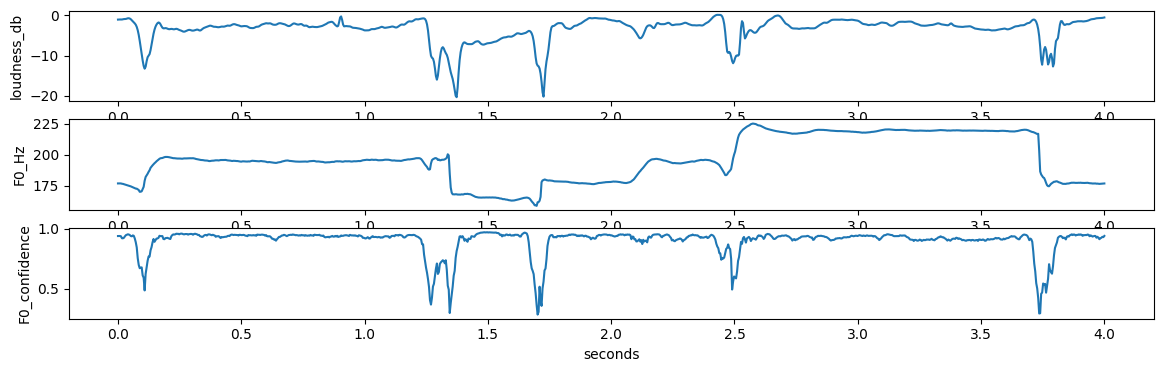

In [6]:
#from ddsp.colab import colab_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# colab_utils.util.specplot(ex['audio'])
# colab_utils.util.play(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])

In [8]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

Reusing TensorBoard on port 6006 (pid 8516), started 13:51:22 ago. (Use '!kill 8516' to kill it.)

In [13]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/solo_instrument.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='data/train.tfrecord*'" \
  --gin_param="batch_size=16" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=300" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"

c:\Users\TheoA\Anaconda3\envs\tflow\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


Original Audio


Resynthesis


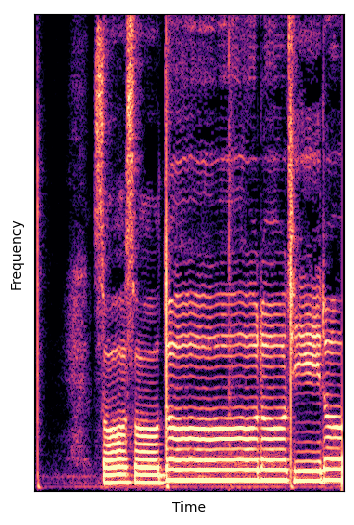

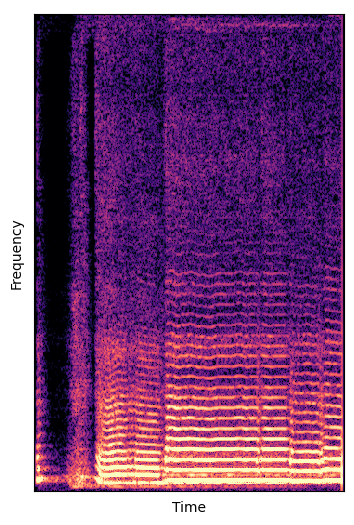

In [5]:
from misc_util import util#util.play, util.specplot
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
util.specplot(audio)
util.play(audio)

print('Resynthesis')
util.specplot(audio_gen)
util.play(audio_gen)